# Tests d'hypothèses statistiques

In [37]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from numpy import random
np.random.seed(77)

## 1) Vérifier vos implémentations avec le test de Kolmogorov Smirnov
- Reprendre vos implémentations de tirages gaussiens (inverse de 'erf' et Box-Muller) et les comparer à la cdf gaussienne
- les comparer entre échantillons
-  Reprendre l'implémentation de la gaussienne tronquée par rejet et par acceptation-rejection et les comparer.

=============== Tests de Kolmogorov-Smirnov ===============

1. Comparaison avec la distribution théorique:

Comparaison Inverse erf vs Gaussienne théorique:
Statistique KS: 0.0059
P-value: 0.8705

Comparaison Box-Muller vs Gaussienne théorique:
Statistique KS: 0.0050
P-value: 0.9616

Comparaison Rejet simple vs Gaussienne théorique:
Statistique KS: 0.0073
P-value: 0.6606

Comparaison Acceptation-rejet vs Gaussienne théorique:
Statistique KS: 0.0071
P-value: 0.6976

2. Comparaisons entre méthodes:

Comparaison Inverse erf vs Box-Muller:
Statistique KS: 0.0096
P-value: 0.7462

Comparaison Inverse erf vs Rejet simple:
Statistique KS: 0.0120
P-value: 0.4676

Comparaison Inverse erf vs Acceptation-rejet:
Statistique KS: 0.0069
P-value: 0.9712

Comparaison Box-Muller vs Rejet simple:
Statistique KS: 0.0063
P-value: 0.9888

Comparaison Box-Muller vs Acceptation-rejet:
Statistique KS: 0.0105
P-value: 0.6399

Comparaison Rejet simple vs Acceptation-rejet:
Statistique KS: 0.0121
P-value: 0.4569

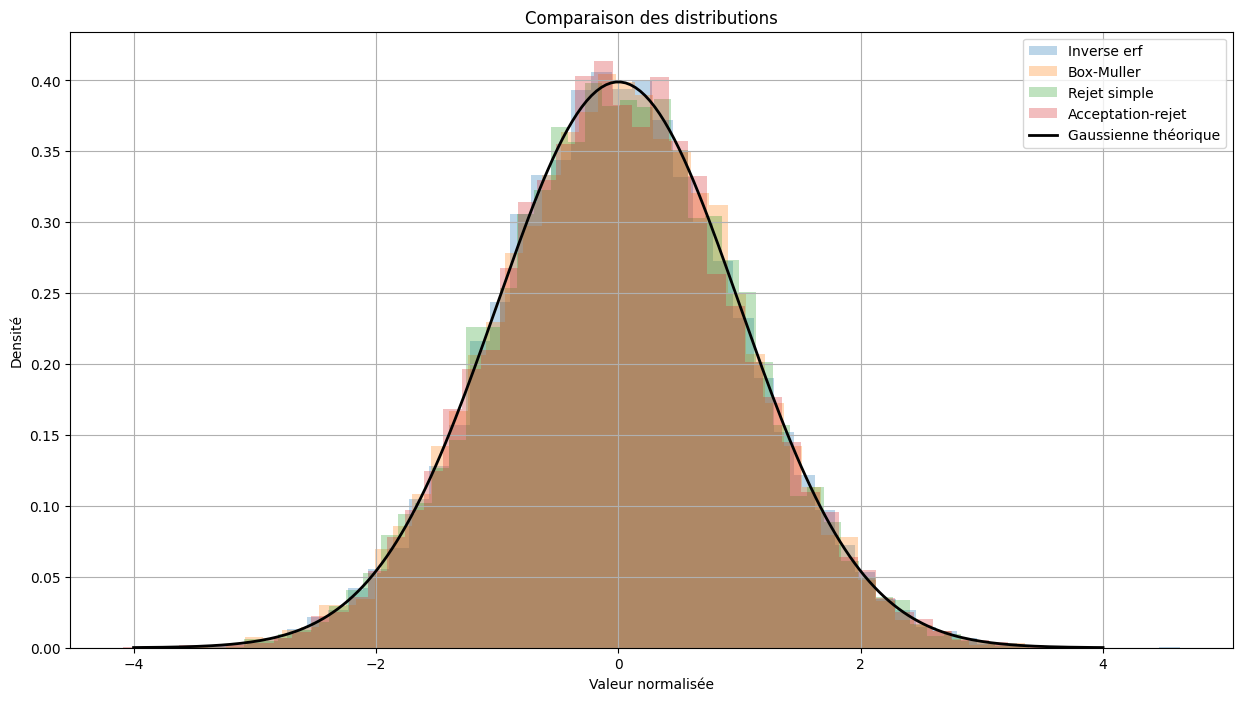

In [38]:
################################ inverse de erf################################ 
def gaussienne_inverse_erf(n_echantillons):
    u = np.random.uniform(0, 1, n_echantillons)
    return np.sqrt(2) * special.erfinv(2 * u - 1)
   
################################ méthode de Box-Muller#########################
def gaussienne_box_muller(n_echantillons):
    n = n_echantillons + (n_echantillons % 2)
    u1 = np.random.uniform(0, 1, n // 2)
    u2 = np.random.uniform(0, 1, n // 2)
    r = np.sqrt(-2 * np.log(u1))
    theta = 2 * np.pi * u2
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.concatenate([x, y])[:n_echantillons]
################################ gaussienne tronquée par rejet simple###########
def gaussienne_tronquee_rejet_simple(n_echantillons, a=-1.5, b=1.5):
    # Calcul des probabilités pour la normalisation
    p_a = stats.norm.cdf(a)
    p_b = stats.norm.cdf(b)
    
    echantillons = []
    n_rejetes = 0
    
    while len(echantillons) < n_echantillons:
        x = np.random.normal()
        if a <= x <= b:
            # Normalisation pour assurer une distribution correcte
            y = (stats.norm.cdf(x) - p_a) / (p_b - p_a)
            echantillons.append(y)
        else:
            n_rejetes += 1
    
    # Transformation inverse pour obtenir une gaussienne standard
    echantillons = np.array(echantillons)
    echantillons = special.ndtri(echantillons) 
    
    taux_rejet = n_rejetes / (n_echantillons + n_rejetes)
    return echantillons, taux_rejet
################################ acceptation-rejet pour une gaussienne tronquée####
def gaussienne_tronquee_acceptation_rejet(n_echantillons, a=-1.5, b=1.5):
    def densite_cible(x):
        return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
    def densite_proposition(x):
        if x < a or x > b:
            return 0
        return 1 / (b - a)
    def generateur_proposition():
        return np.random.uniform(a, b) 
    # Calcul précis de M
    x_grille = np.linspace(a, b, 10000)
    ratios = [densite_cible(x) / densite_proposition(x) if densite_proposition(x) > 0 else 0 for x in x_grille]
    M = max(ratios) * 1.01 
    
    echantillons = []
    n_rejetes = 0
    
    # Calcul des probabilités pour la normalisation
    p_a = stats.norm.cdf(a)
    p_b = stats.norm.cdf(b)           
    
    while len(echantillons) < n_echantillons:
        x = generateur_proposition()
        u = np.random.uniform(0, 1)
        
        taux_acceptation = densite_cible(x) / (M * densite_proposition(x))
        
        if u <= taux_acceptation:
            # Normalisation pour obtenir une gaussienne standard
            p = (stats.norm.cdf(x) - p_a) / (p_b - p_a)
            z = special.ndtri(p)  # Transformation inverse
            echantillons.append(z)
        else:
            n_rejetes += 1
    taux_rejet = n_rejetes / (n_echantillons + n_rejetes)
    return np.array(echantillons), taux_rejet   


#Normalise les échantillons.
def normaliser_echantillons(echantillons):
    return (echantillons - np.mean(echantillons)) / np.std(echantillons)

def comparer_avec_theorique(echantillons, nom_methode):
    echantillons_norm = normaliser_echantillons(echantillons)
    ks_stat, p_value = stats.kstest(echantillons_norm, 'norm')
    print(f"\nComparaison {nom_methode} vs Gaussienne théorique:")
    print(f"Statistique KS: {ks_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    return ks_stat, p_value

def comparer_echantillons(echantillons1, echantillons2, nom_methode1, nom_methode2):
    echantillons1_norm = normaliser_echantillons(echantillons1)
    echantillons2_norm = normaliser_echantillons(echantillons2)
    
    ks_stat, p_value = stats.ks_2samp(echantillons1_norm, echantillons2_norm)
    print(f"\nComparaison {nom_methode1} vs {nom_methode2}:")
    print(f"Statistique KS: {ks_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    return ks_stat, p_value


# Génération des échantillons
n_echantillons = 10000
echantillons_erf = gaussienne_inverse_erf(n_echantillons)
echantillons_bm = gaussienne_box_muller(n_echantillons)
echantillons_rejet, taux_rejet_rejet = gaussienne_tronquee_rejet_simple(n_echantillons)
echantillons_acceptation_rejet, taux_rejet_acceptation = gaussienne_tronquee_acceptation_rejet(n_echantillons)

# Création du dictionnaire des échantillons
dictionnaire_echantillons = {
    'Inverse erf': (echantillons_erf, 0),
    'Box-Muller': (echantillons_bm, 0),
    'Rejet simple': (echantillons_rejet, taux_rejet_rejet),
    'Acceptation-rejet': (echantillons_acceptation_rejet, taux_rejet_acceptation)
}

# Tests de Kolmogorov-Smirnov
print("=============== Tests de Kolmogorov-Smirnov ===============")
print("\n1. Comparaison avec la distribution théorique:")
for nom, (echantillons, _) in dictionnaire_echantillons.items():
    comparer_avec_theorique(echantillons, nom)

print("\n2. Comparaisons entre méthodes:")
methodes = list(dictionnaire_echantillons.keys())
for i in range(len(methodes)):
    for j in range(i + 1, len(methodes)):
        comparer_echantillons(
            dictionnaire_echantillons[methodes[i]][0],
            dictionnaire_echantillons[methodes[j]][0],
            methodes[i],
            methodes[j]
        )

# Visualisations
plt.figure(figsize=(15, 8))

for nom, (echantillons, _) in dictionnaire_echantillons.items():
    echantillons_norm = normaliser_echantillons(echantillons)
    plt.hist(echantillons_norm, bins=50, density=True, alpha=0.3, label=nom)

x = np.linspace(-4, 4, 200)
plt.plot(x, stats.norm.pdf(x), 'k-', linewidth=2, label='Gaussienne théorique')

plt.title("Comparaison des distributions")
plt.xlabel("Valeur normalisée")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.show()

###  Conclusion des hypothèses

La p-value pour les tests précédents est toujours supérieure à 0.05, ce qui permet de ne pas rejeter l'hypothèse que ces méthode génère la même loi gaussienne.



###  Comparaison des CDFs: gaussienne théorique + inverse erf + Box-Muller

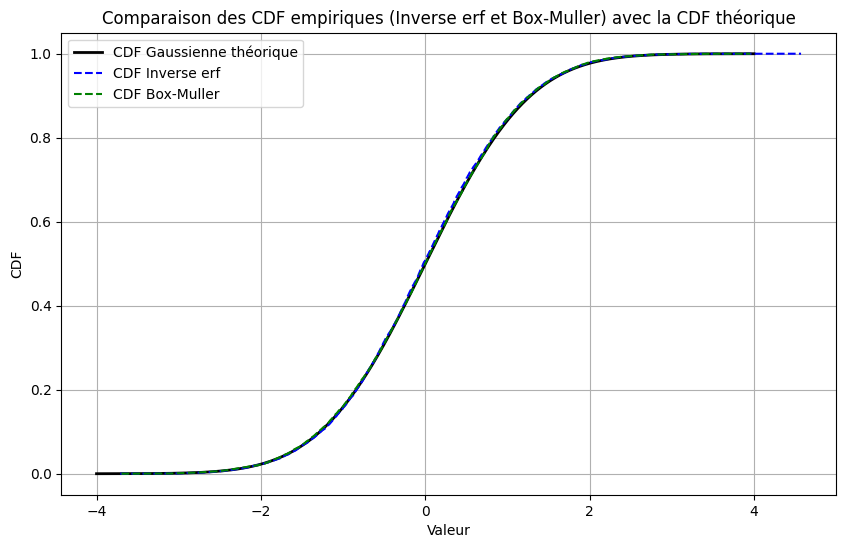

In [39]:
plt.figure(figsize=(10, 6))

# CDF théorique de la gaussienne standard
x = np.linspace(-4, 4, 1000)
plt.plot(x, stats.norm.cdf(x), label='CDF Gaussienne théorique', color='black', linewidth=2)

# CDF empirique de la méthode inverse erf
ecdf_erf = np.sort(echantillons_erf)
plt.plot(ecdf_erf, np.linspace(0, 1, len(ecdf_erf)), linestyle='--', label='CDF Inverse erf', color='blue')

# CDF empirique de la méthode Box-Muller
ecdf_bm = np.sort(echantillons_bm)
plt.plot(ecdf_bm, np.linspace(0, 1, len(ecdf_bm)), linestyle='--', label='CDF Box-Muller', color='green')

plt.title("Comparaison des CDF empiriques (Inverse erf et Box-Muller) avec la CDF théorique")
plt.xlabel("Valeur")
plt.ylabel("CDF")
plt.legend()
plt.grid(True)
plt.show()

## 2) A partir d'un échantillon expérimental

Dans la 'cell' qui suit, vous avez un échantillon de résultats expérimentaux
- émettre une hypothèse gaussienne (moyenne? Variance?) quant à sa distribution
  - la tester
  - commenter
- émettre une seconde hypothèse (uniforme? De moyenne? De variance?) quant à sa distribution 
  - la tester
  - commenter
- Que penser de l'hypothèse: "les points ci-dessous sont des réalisations de tirages exponentiels de paramètres $\lambda=3.75$

Quelle distribution conseiller entre les deux précédemment testées? Avez-vous des suggestions à faire en terme d'aide à la décision? 



À partir d'un échantillon de données expérimentales, nous testons plusieurs hypothèses pour identifier la distribution qui semble la plus appropriée.

1. **Hypothèse Gaussienne** : Nous vérifions si les données pourraient provenir d'une distribution normale en calculant la moyenne et la variance de l'échantillon, puis en appliquant le test de Kolmogorov-Smirnov. La p-value du test indique si les données sont compatibles avec la distribution normale.
  
2. **Hypothèse Uniforme** : Nous supposons ici que les données suivent une distribution uniforme sur l'intervalle $[ \text{min}(X), \text{max}(X) ]$ et utilisons encore le test KS pour vérifier cette hypothèse.

3. **Hypothèse Exponentielle** : Nous testons si les données pourraient provenir d'une loi exponentielle de paramètre $\lambda = 3.75$. Si la p-value est faible, nous rejetons cette hypothèse.

### Code Python


In [40]:
# Échantillon expérimental
X = np.array([0.97470374, 2.01811673, 5.25518876, 3.17088334, 2.43179837,
              1.44321658, 2.89195882, 8.73129971, 6.9308039, 3.68360766])

# 1. Hypothèse gaussienne
moyenne_X, ecart_type_X = np.mean(X), np.std(X)
ks_gaussienne = stats.kstest(X, 'norm', args=(moyenne_X, ecart_type_X))
print("=============Test KS pour hypothèse gaussienne================")
print("statistique ks :", ks_gaussienne.statistic)
print("p-value :", ks_gaussienne.pvalue)
# 2. Hypothèse uniforme
min_X, max_X = np.min(X), np.max(X)
ks_uniforme = stats.kstest(X, 'uniform', args=(min_X, max_X - min_X))
print("=============Test KS pour hypothèse uniforme==================")
print("statistique ks :", ks_uniforme.statistic)
print("p-value :", ks_uniforme.pvalue)
# 3. Hypothèse exponentielle
lambda_exp = 3.75
ks_exponentielle = stats.kstest(X, 'expon', args=(0, 1/lambda_exp))
print("=============Test KS pour hypothèse exponentielle=============")
print("statistique ks :", ks_exponentielle.statistic)
print("p-value :", ks_exponentielle.pvalue)


=============Test KS pour hypothèse gaussienne================
statistique ks : 0.21171989010599324
p-value : 0.6871190745725402
=============Test KS pour hypothèse uniforme==================
statistique ks : 0.35076124494853633
p-value : 0.13241303742814914
=============Test KS pour hypothèse exponentielle=============
statistique ks : 0.9741420976616086
p-value : 2.67277810024708e-16



### Conclusions
- **Hypothèse Gaussienne** :
  - La p-value élevée (0.6871) nous conduit à **ne pas rejeter l'hypothèse** que les données suivent une loi normale.

- **Hypothèse Uniforme** :
  - La p-value est relativement élevée (0.1324), nous ne rejetons donc pas l'hypothèse que les données suivent une loi uniforme.

- **Hypothèse Exponentielle** :
  - La p-value extrêmement faible (2.6728e-16) nous conduit à **rejeter l'hypothèse** que les données suivent une distribution exponentielle avec $ \lambda = 3.75 $. L’échantillon expérimental ne semble donc pas provenir d’une loi exponentielle.
 
- Sur la base des tests, la distribution gaussienne est conseillée pour modéliser les données expérimentales, car elle présente une p-value plus élevée, indiquant une meilleure correspondance avec l'échantillon.

- Pour l'aide à la décision on peut utiliser le tracé suivant:

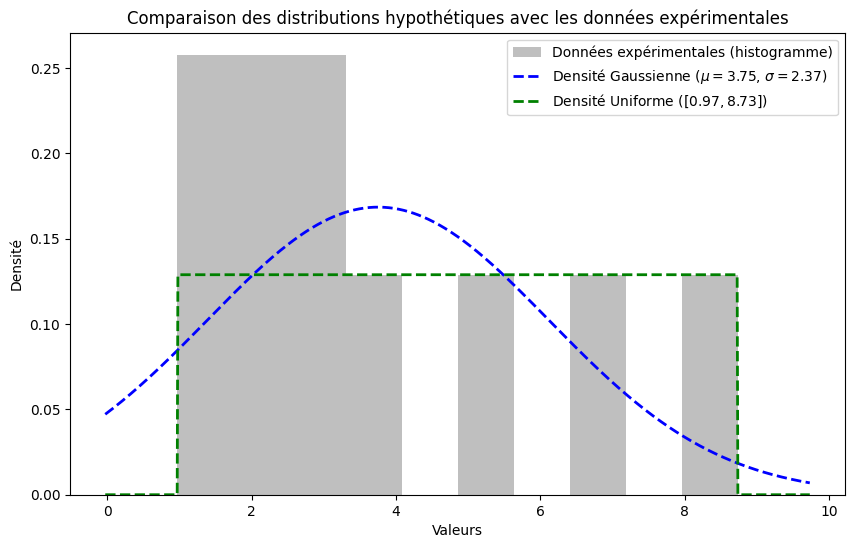

In [41]:
# Liste des valeurs de x pour le tracé
valeurs_x = np.linspace(min_X - 1, max_X + 1, 1000)

# La densité de probabilité gaussienne
densite_gaussienne = stats.norm.pdf(valeurs_x, moyenne_X, ecart_type_X)

# La densité de probabilité uniforme
densite_uniforme = stats.uniform.pdf(valeurs_x, loc=min_X, scale=max_X - min_X)

# Tracé
plt.figure(figsize=(10, 6))

# Histogramme des données expérimentales
plt.hist(X, bins=10, density=True, alpha=0.5, color='gray', label='Données expérimentales (histogramme)')

# Tracé de la distribution gaussienne
plt.plot(valeurs_x, densite_gaussienne, color='blue', linestyle='--', linewidth=2,
         label=f'Densité Gaussienne ($\mu={moyenne_X:.2f}$, $\sigma={ecart_type_X:.2f}$)')

# Tracé de la distribution uniforme
plt.plot(valeurs_x, densite_uniforme, color='green', linestyle='--', linewidth=2,
         label=f'Densité Uniforme ($[{min_X:.2f}, {max_X:.2f}]$)')

# Étiquettes et légende
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.title("Comparaison des distributions hypothétiques avec les données expérimentales")
plt.legend()
plt.show()


## 3) Validation de modèle

Nous disposons de deux modèles physiques au travers desquels ont été propagés des incertitudes. 
- Pour le premier modèle, la sortie est distribuée selon une loi uniforme sur $[0,3]$
- Pour le second modèle, la sortie est distribuée selon une loi gaussienne de moyenne 0 et de variance 1.

Selon vous, les deux modèles ont-ils les mêmes performances en terme de moyenne? Justifier de manière quantifiée

In [42]:
# Comparaison des moyennes des deux modèles
# Modèle 1 : uniforme sur [0, 3]
echantillons_modele1 = np.random.uniform(0, 3, 1000)
moyenne_modele1 = np.mean(echantillons_modele1)

# Modèle 2 : gaussienne de moyenne 0 et variance 1
echantillons_modele2 = np.random.normal(0, 1, 1000)
moyenne_modele2 = np.mean(echantillons_modele2)

# Affichage des moyennes
print("Moyenne du Modèle 1 (Uniforme [0, 3]) :", moyenne_modele1)
print("Moyenne du Modèle 2 (Normale mu=0, sigma²=1) :", moyenne_modele2)

# Test statistique pour la différence de moyenne
t_stat, p_value= stats.ttest_ind(echantillons_modele1, echantillons_modele2)
print("Test de comparaison de moyenne (t-statistique) :", t_stat)
print("p-value :", p_value)


Moyenne du Modèle 1 (Uniforme [0, 3]) : 1.4979652975517113
Moyenne du Modèle 2 (Normale mu=0, sigma²=1) : 0.005591767153478669
Test de comparaison de moyenne (t-statistique) : 36.31971661666431
p-value : 3.204256804107841e-222


### Résultats
- **Moyenne du Modèle 1 (Uniforme [0, 3])** : 1.497
- **Moyenne du Modèle 2 (Normale $ \mu=0, \sigma^2=1 $)** : 0.005
- **Test de comparaison de moyenne (t-statistique)** : 36.31
- **p-value** : 3.20e-222

### Interprétation
Le test montre une p-value trop faible, ce qui indique une différence importante entre les moyennes des deux modèles. Le Modèle 1 (uniforme) a une moyenne autour de 1.5, alors que le Modèle 2 (normal) a une moyenne proche de 0.
Nous **rejetons donc l'hypothèse** que les deux modèles ont des moyennes similaires.

